In [4]:
with open('lstm_model.pkl', 'rb') as file:
    lstm = pickle.load(file)
print("Loaded Model")

Loaded Model


In [23]:
import numpy as np
import pandas as pd
import networkx as nx
from heapq import heappop, heappush
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle

In [68]:
# Generate synthetic traffic data with multiple parameters for 100 nodes
def generate_random_traffic_data(num_nodes=50, num_edges=200):
    np.random.seed(42)
    nodes = [f'Node{i}' for i in range(num_nodes)]
    data = {
        'source': np.random.choice(nodes, num_edges),
        'target': np.random.choice(nodes, num_edges),
        'traffic_flow': np.random.randint(50, 200, num_edges),
        'speed': np.random.uniform(30, 80, num_edges),
        'incident': np.random.choice([0, 1], num_edges),  # 0: No incident, 1: Incident
        'weather': np.random.uniform(0, 1, num_edges),  # 0: Clear, 1: Severe
        'day_of_week': np.random.choice(range(7), num_edges),  # 0: Monday, 6: Sunday
        'time_of_day': np.random.choice(range(24), num_edges),  # 0: Midnight, 23: 11 PM
        'events': np.random.choice([0, 1], num_edges),  # 0: No event, 1: Event
        'road_condition': np.random.randint(1, 5, num_edges),
        'public_transport': np.random.choice([0, 1], num_edges),  # 0: No PT, 1: PT available
        'latitude_source': np.random.uniform(-90, 90, num_edges),
        'longitude_source': np.random.uniform(-180, 180, num_edges),
        'latitude_target': np.random.uniform(-90, 90, num_edges),
        'longitude_target': np.random.uniform(-180, 180, num_edges)
    }
    return pd.DataFrame(data)

In [69]:
# Predict future traffic flow
def predict_future_traffic(data, model, scaler, seq_length=30, steps=10):
    features = ['traffic_flow', 'speed', 'incident', 'weather', 'day_of_week', 'time_of_day', 'events', 'road_condition', 'public_transport']
    scaled_values = scaler.transform(data[features].values)
    current_sequence = scaled_values[-seq_length:]
    predictions = []

    for _ in range(steps):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction[0])
        prediction = np.hstack((prediction, np.zeros((1, len(features) - 1))))
        current_sequence = np.concatenate([current_sequence[1:], prediction], axis=0)

    predictions = scaler.inverse_transform(np.hstack((np.array(predictions), np.zeros((steps, len(features) - 1)))))
    return predictions

In [70]:
def create_graph(data, future_traffic):
    G = nx.DiGraph()
    future_traffic_dict = dict(zip(data['source'] + '-' + data['target'], future_traffic.flatten()))

    def calculate_weight(row):
        key = row['source'] + '-' + row['target']
        traffic_flow = future_traffic_dict.get(key, row['traffic_flow'])
        road_condition = row['road_condition']
        return traffic_flow * 0.7 + road_condition * 0.3

    for _, row in data.iterrows():
        weight = calculate_weight(row)
        G.add_edge(row['source'], row['target'], weight=weight, latitude_source=row['latitude_source'], longitude_source=row['longitude_source'], latitude_target=row['latitude_target'], longitude_target=row['longitude_target'])

    return G

In [71]:
def heuristic(a, b, G):
    coord_a = (G.nodes[a]['latitude'], G.nodes[a]['longitude'])
    coord_b = (G.nodes[b]['latitude'], G.nodes[b]['longitude'])
    return geodesic(coord_a, coord_b).kilometers

def astar_path(graph, start, goal):
    queue = [(0, start, [])]
    seen = set()
    min_cost = {start: 0}

    while queue:
        (cost, current, path) = heappop(queue)

        if current in seen:
            continue

        path = path + [current]
        seen.add(current)

        if current == goal:
            return path

        for neighbor, attr in graph[current].items():
            weight = attr['weight']
            old_cost = min_cost.get(neighbor, float('inf'))
            new_cost = cost + weight
            if new_cost < old_cost:
                min_cost[neighbor] = new_cost
                heappush(queue, (new_cost + heuristic(neighbor, goal, graph), neighbor, path))

    return []

In [72]:
def preprocess_graph(graph):
    ch = nx.floyd_warshall(graph)
    return ch

def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
    path = astar_path(graph, start, end)
    total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))

    vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
    travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)

    return travel_time, path

def visualize_graph_and_path(graph, path):
    pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
    edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
    plt.title('Graph with Shortest Path Highlighted')
    plt.show()

1/1 [==============================] - 0s 65ms/step
Sample Input: Current Time - 12, Vehicle Type - car, Source - Node22, Destination - Node6
Predicted Travel Time: 141.8828264995836 hours
Shortest Path: ['Node22', 'Node38', 'Node14', 'Node46', 'Node6']


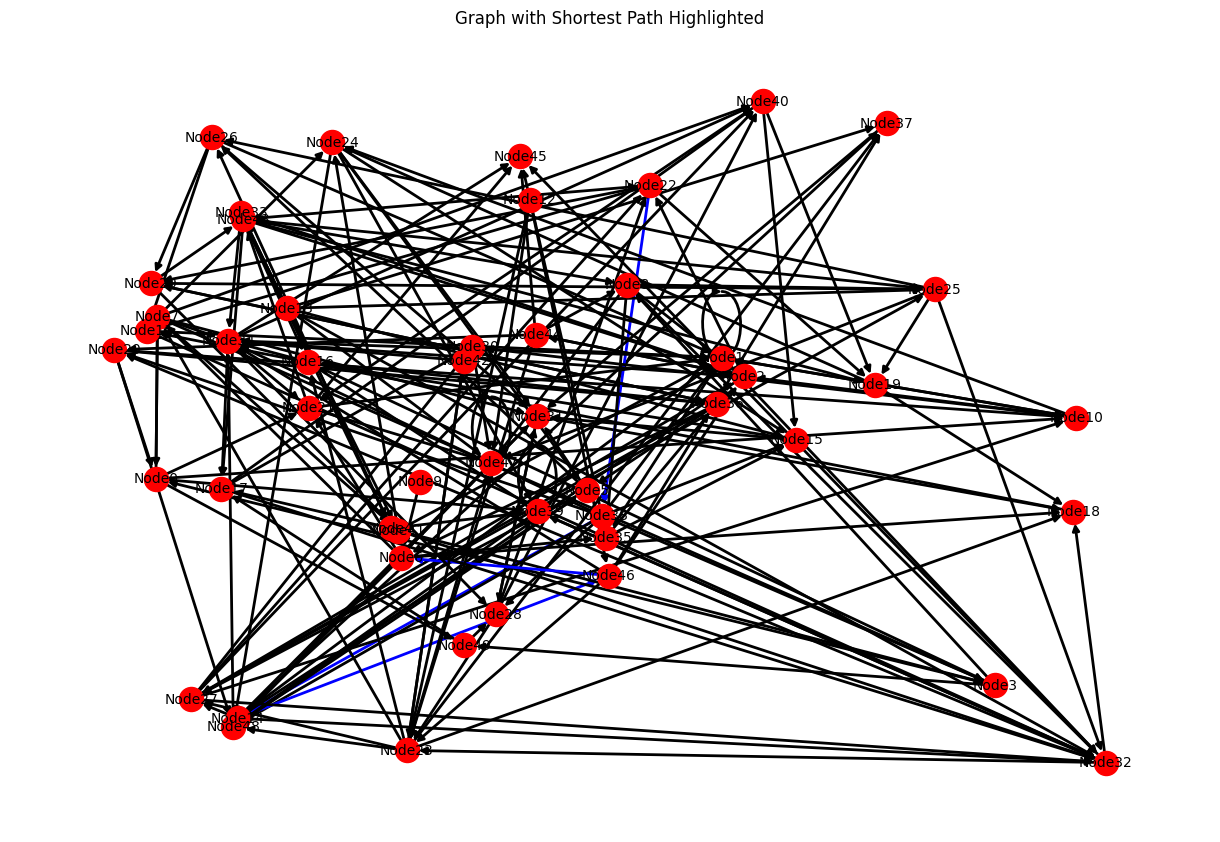

Sample Input: Current Time - 16, Vehicle Type - bus, Source - Node45, Destination - Node40
Predicted Travel Time: 229.24999999999997 hours
Shortest Path: ['Node40', 'Node21', 'Node45']


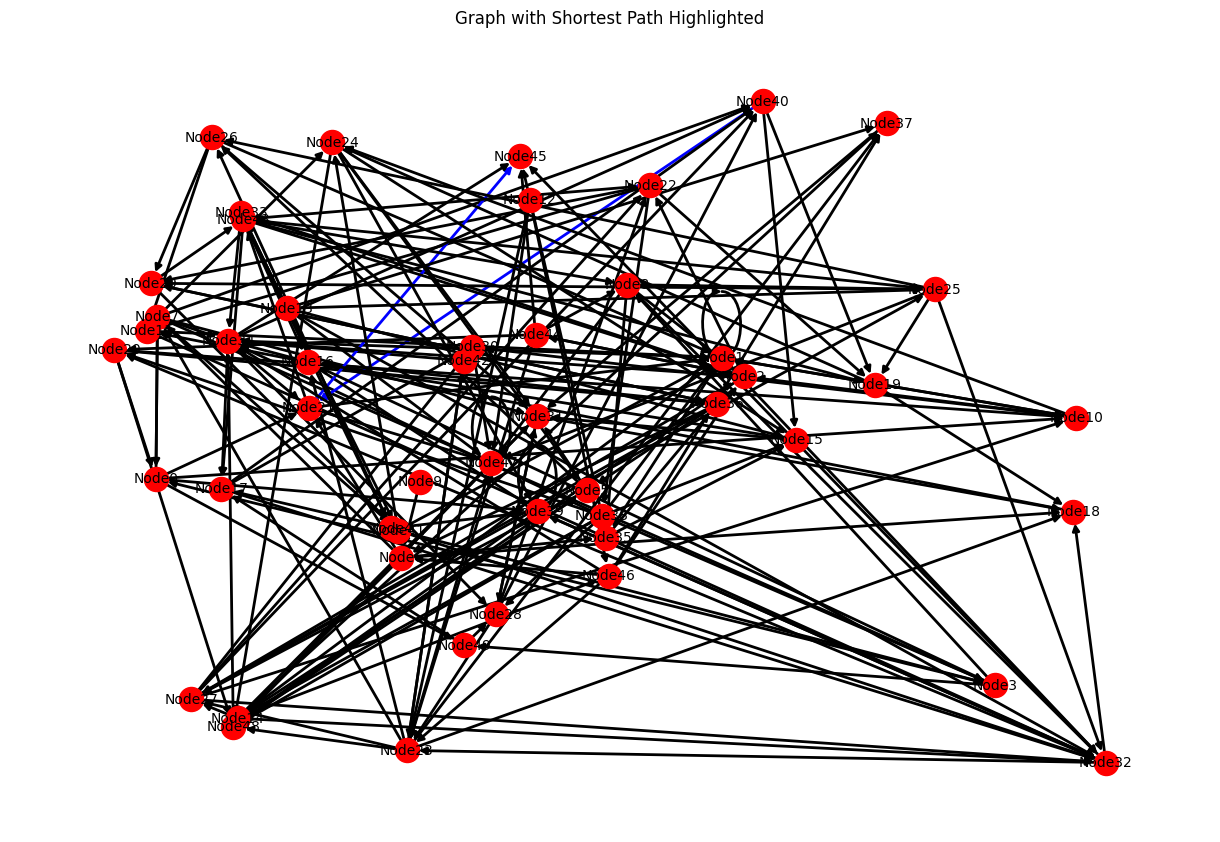

Sample Input: Current Time - 10, Vehicle Type - car, Source - Node32, Destination - Node8
Predicted Travel Time: 193.93603179459717 hours
Shortest Path: ['Node32', 'Node20', 'Node10', 'Node2', 'Node44', 'Node8']


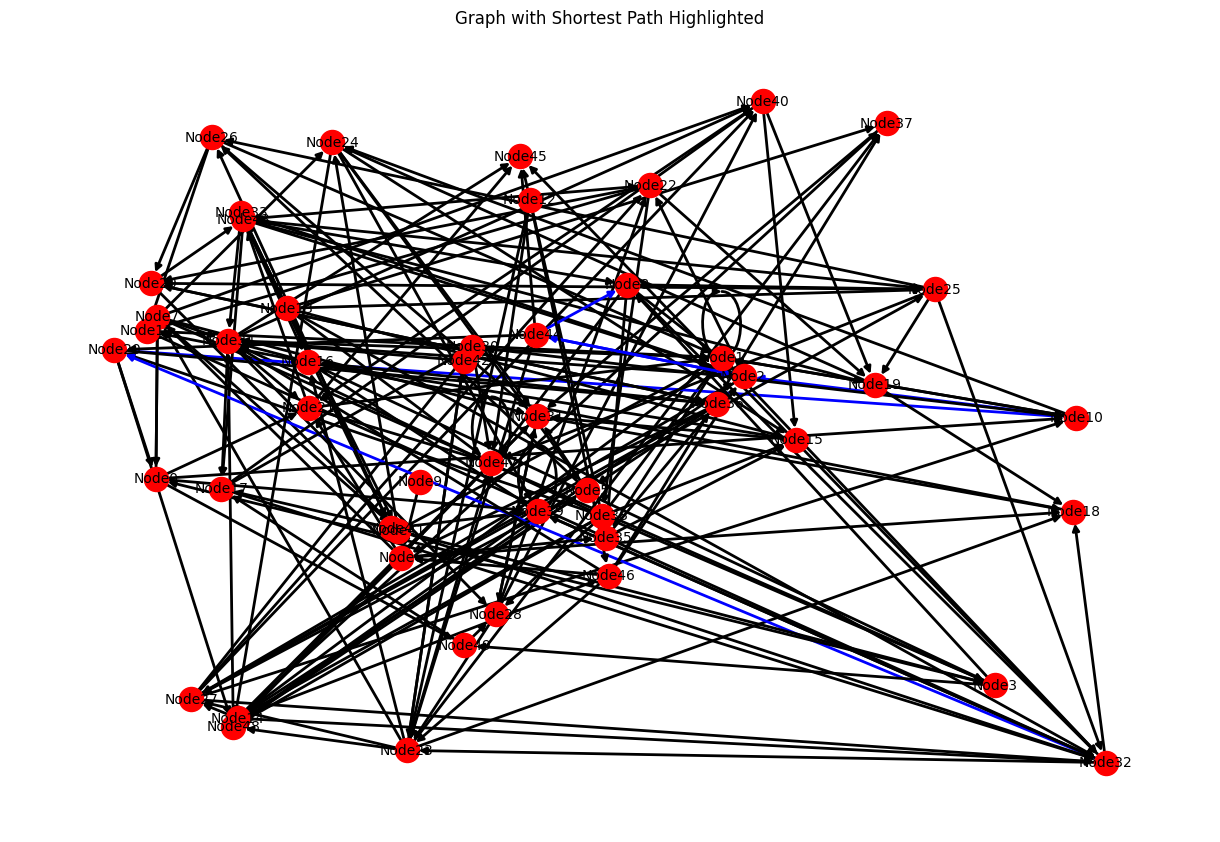

Sample Input: Current Time - 20, Vehicle Type - car, Source - Node45, Destination - Node13
Predicted Travel Time: 267.93603179459717 hours
Shortest Path: ['Node13', 'Node33', 'Node34', 'Node45']


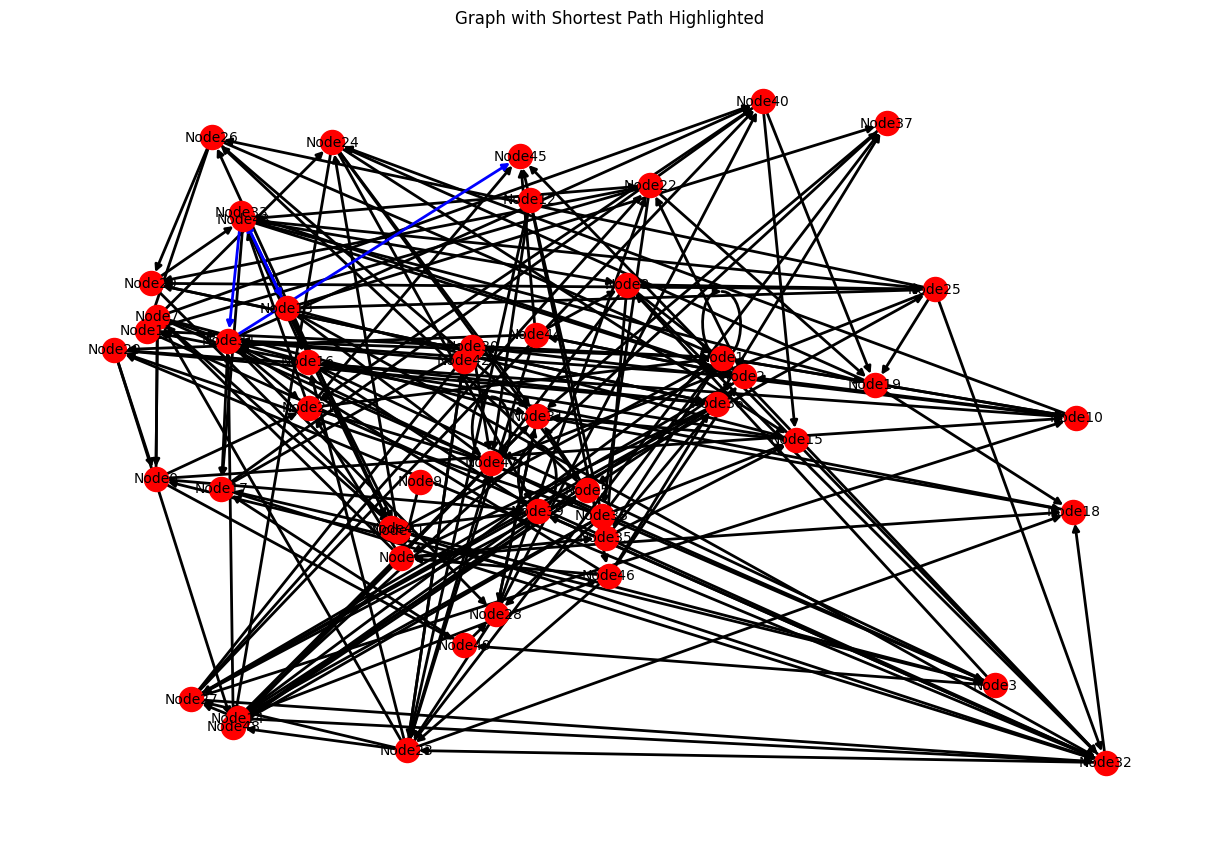

Sample Input: Current Time - 10, Vehicle Type - bus, Source - Node17, Destination - Node20
Predicted Travel Time: 71.37499999999999 hours
Shortest Path: ['Node17', 'Node32', 'Node20']


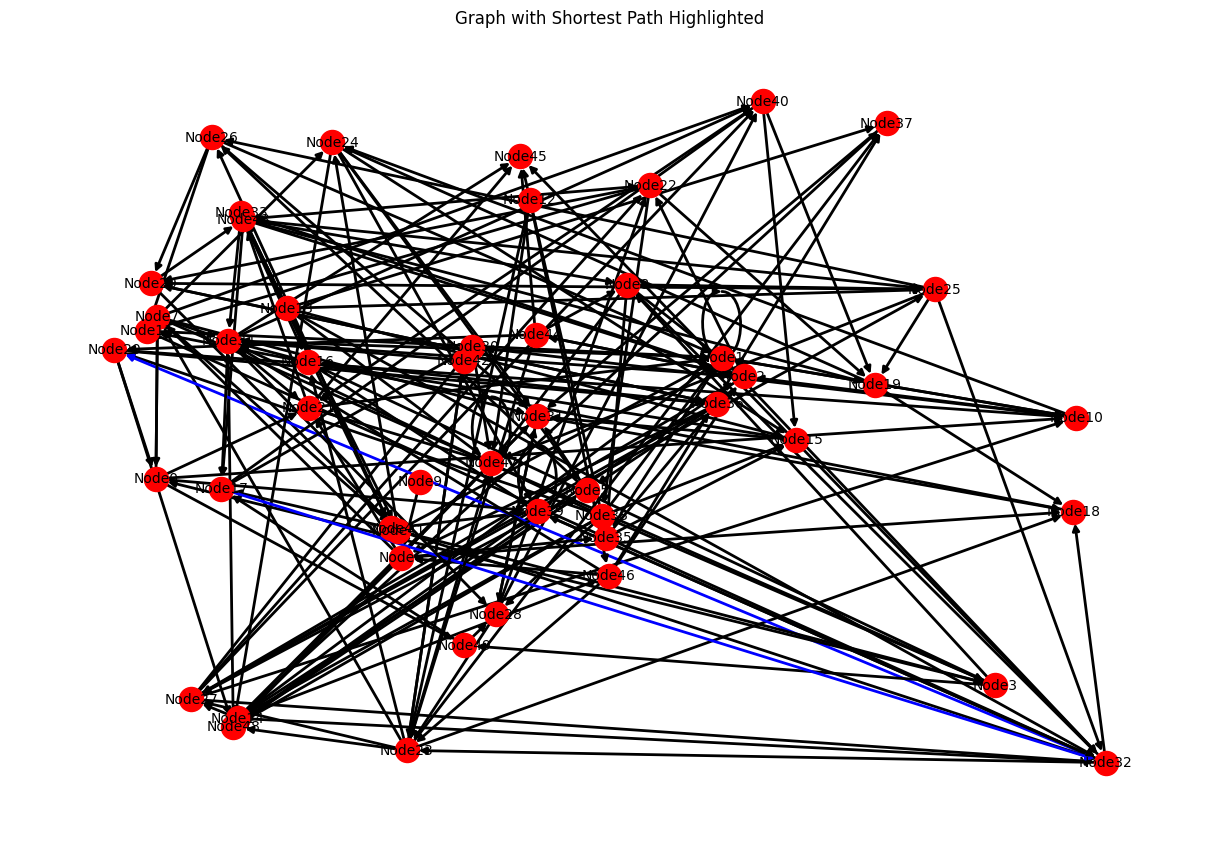

In [73]:

traffic_data = generate_random_traffic_data()
lstm_model = lstm
with open('lstm_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
future_traffic = predict_future_traffic(traffic_data, lstm_model, scaler)
G = create_graph(traffic_data, future_traffic)
for node in G.nodes():
        source_nodes = traffic_data[traffic_data['source'] == node]
        if not source_nodes.empty:
            G.nodes[node]['latitude'] = source_nodes['latitude_source'].values[0]
            G.nodes[node]['longitude'] = source_nodes['longitude_source'].values[0]
        else:
            target_nodes = traffic_data[traffic_data['target'] == node]
            if not target_nodes.empty:
                G.nodes[node]['latitude'] = target_nodes['latitude_target'].values[0]
                G.nodes[node]['longitude'] = target_nodes['longitude_target'].values[0]

preprocessed_graph = preprocess_graph(G)

def get_sample_inputs():
        current_time = np.random.randint(0, 24)
        vehicle_type = np.random.choice(['car', 'bus', 'bike'])
        source = np.random.choice(list(G.nodes()))
        destination = np.random.choice(list(G.nodes()))
        return current_time, vehicle_type, source, destination

def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
        path = astar_path(graph, start, end)
        total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
        travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)
        return travel_time, path

def visualize_graph_and_path(graph, path):
        pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
        edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

        plt.figure(figsize=(12, 8))
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
        plt.title('Graph with Shortest Path Highlighted')
        plt.show()

for _ in range(5):
            current_time, vehicle_type, source, destination = get_sample_inputs()
            travel_time, path = predict_travel_time_and_path(G, source, destination, current_time, vehicle_type)
            if travel_time == 0:
                travel_time, path = predict_travel_time_and_path(G, destination, source,  current_time, vehicle_type)
            print(f"Sample Input: Current Time - {current_time}, Vehicle Type - {vehicle_type}, Source - {source}, Destination - {destination}")
            print(f"Predicted Travel Time: {travel_time} hours")
            print(f"Shortest Path: {path}")
            visualize_graph_and_path(G, path)

In [45]:
print(type(current_time))
print(type(vehicle_type))
print(type(source))
print(type(destination))
print(type(travel_time))
print(type(path))

<class 'int'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.float64'>
<class 'list'>


In [38]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s et

In [49]:
import gradio as gr

traffic_data = generate_random_traffic_data()
lstm_model = lstm
with open('lstm_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
future_traffic = predict_future_traffic(traffic_data, lstm_model, scaler)
G = create_graph(traffic_data, future_traffic)
for node in G.nodes():
        source_nodes = traffic_data[traffic_data['source'] == node]
        if not source_nodes.empty:
            G.nodes[node]['latitude'] = source_nodes['latitude_source'].values[0]
            G.nodes[node]['longitude'] = source_nodes['longitude_source'].values[0]
        else:
            target_nodes = traffic_data[traffic_data['target'] == node]
            if not target_nodes.empty:
                G.nodes[node]['latitude'] = target_nodes['latitude_target'].values[0]
                G.nodes[node]['longitude'] = target_nodes['longitude_target'].values[0]

preprocessed_graph = preprocess_graph(G)

def get_sample_inputs():
        current_time = np.random.randint(0, 24)
        vehicle_type = np.random.choice(['car', 'bus', 'bike'])
        source = np.random.choice(list(G.nodes()))
        destination = np.random.choice(list(G.nodes()))
        return current_time, vehicle_type, source, destination

def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
        path = astar_path(graph, start, end)
        total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
        travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)
        return travel_time, path

def visualize_graph_and_path(graph, path):
        pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
        edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

        plt.figure(figsize=(12, 8))
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
        plt.title('Graph with Shortest Path Highlighted')
        plt.show()
'''
for _ in range(5):
            current_time, vehicle_type, source, destination = get_sample_inputs()
            travel_time, path = predict_travel_time_and_path(G, source, destination, current_time, vehicle_type)
            if travel_time == 0:
                travel_time, path = predict_travel_time_and_path(G, destination, source,  current_time, vehicle_type)
            print(f"Sample Input: Current Time - {current_time}, Vehicle Type - {vehicle_type}, Source - {source}, Destination - {destination}")
            print(f"Predicted Travel Time: {travel_time} hours")
            print(f"Shortest Path: {path}")
            visualize_graph_and_path(G, path)
'''
def text_to_np_str(text):
    return np.array([np.str_(text)], dtype=np.str_)

def numpy_array_to_str(array):
    return array.astype(str)

# Function to predict travel time and path
def predict_travel_time_and_path_interface(current_time, vehicle_type, source, destination):
    # Convert text inputs to numpy.str_
    vehicle_type = text_to_np_str(vehicle_type)
    source = str(source[0])  # Assuming source and destination are single-element numpy arrays
    destination = str(destination[0])

    travel_time, path = predict_travel_time_and_path(G, source, destination, current_time, vehicle_type)

    # Convert path to a list of strings for Gradio interface
    path_as_list = [str(node) for node in path]

    return {
        'Travel Time': numpy_array_to_str(travel_time),  # Convert numpy.float64 to float for Gradio interface
        'Path': path_as_list
    }


def visualize_graph_and_path_interface(source, destination):
    vehicle_type = text_to_np_str(vehicle_type)
    source = text_to_np_str(source)
    destination = text_to_np_str(destination)
    _, path = predict_travel_time_and_path(G, source, destination, travel_time, vehicle_type)
    visualize_graph_and_path(G, path)

predict_interface = gr.Interface(
    fn=predict_travel_time_and_path_interface,
    inputs=['number', 'text', 'text', 'text'],
    outputs=['text', 'text'],
    title='Predict Travel Time and Path',
    description='Enter current time (0-23), vehicle type (car/bus/bike), source, and destination.'
)

visualize_interface = gr.Interface(
    fn=visualize_graph_and_path_interface,
    inputs=['text', 'text'],
    outputs=None,
    title='Visualize Shortest Path',
    description='Enter source and destination to visualize the shortest path on the graph.'
)

predict_interface.launch(debug = True)
visualize_interface.launch(debug = True)


1/1 [==============================] - 0s 34ms/step
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c37e434ba9dcb3fd9f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 532, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1928, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1514, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7868 <> https://c37e434ba9dcb3fd9f.gradio.live
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://895d69532e9fa00d5f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7868 <> https://895d69532e9fa00d5f.gradio.live


In [50]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [51]:
import streamlit as st
import numpy as np
import networkx as nx

def main():

    traffic_data = generate_random_traffic_data()
    lstm_model = lstm
    with open('lstm_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
    future_traffic = predict_future_traffic(traffic_data, lstm_model, scaler)
    G = create_graph(traffic_data, future_traffic)
    for node in G.nodes():
            source_nodes = traffic_data[traffic_data['source'] == node]
            if not source_nodes.empty:
                G.nodes[node]['latitude'] = source_nodes['latitude_source'].values[0]
                G.nodes[node]['longitude'] = source_nodes['longitude_source'].values[0]
            else:
                target_nodes = traffic_data[traffic_data['target'] == node]
                if not target_nodes.empty:
                    G.nodes[node]['latitude'] = target_nodes['latitude_target'].values[0]
                    G.nodes[node]['longitude'] = target_nodes['longitude_target'].values[0]

    preprocessed_graph = preprocess_graph(G)

    def get_sample_inputs():
            current_time = np.random.randint(0, 24)
            vehicle_type = np.random.choice(['car', 'bus', 'bike'])
            source = np.random.choice(list(G.nodes()))
            destination = np.random.choice(list(G.nodes()))
            return current_time, vehicle_type, source, destination

    def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
            path = astar_path(graph, start, end)
            total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
            vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
            travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)
            return travel_time, path

    def visualize_graph_and_path(graph, path):
            pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
            edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

            plt.figure(figsize=(12, 8))
            nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
            plt.title('Graph with Shortest Path Highlighted')
            plt.show()

    st.title('Predict Travel Time and Path')
    st.sidebar.title('Settings')

    current_time = st.sidebar.number_input('Current Time (0-23)', min_value=0, max_value=23, value=12)
    vehicle_type = st.sidebar.selectbox('Vehicle Type', ['car', 'bus', 'bike'])
    source = st.sidebar.text_input('Source')
    destination = st.sidebar.text_input('Destination')

    if st.sidebar.button('Predict'):
        source = np.array([source], dtype=np.str_)
        destination = np.array([destination], dtype=np.str_)
        vehicle_type = np.array([vehicle_type], dtype=np.str_)
        travel_time, path = predict_travel_time_and_path(G, source, destination, current_time, vehicle_type)
        st.write(f"Predicted Travel Time: {travel_time} hours")
        st.write("Path:", path)
        visualize_graph_and_path(G, path)

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 28ms/step


2024-06-14 20:58:58.571 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-06-14 20:58:58.574 Session state does not function when running a script without `streamlit run`


In [57]:
!pip install streamlit pyngrok

nohup: appending output to 'nohup.out'


ERROR:pyngrok.process.ngrok:t=2024-06-14T21:02:05+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-06-14T21:02:05+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-06-14T21:02:05+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [60]:
import os
from pyngrok import ngrok

# Replace 'your_ngrok_authtoken' with your actual Ngrok authtoken
ngrok.set_auth_token('2ht2UkAVlz42G1kdpPUGV4mtuck_77NFQ8VB7D9fabMqUmiLt')

# Now you can connect using Ngrok
public_url = ngrok.connect(port='8501')
print(f"Streamlit app is running at {public_url}")


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [59]:
from pyngrok import ngrok

# Start Streamlit app in the background
!nohup streamlit run usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py &

# Setup a tunnel to the Streamlit port 8501
public_url = ngrok.connect(port='8501')
print(f"Streamlit app is running at {public_url}")

# Keep the Colab session active while the Streamlit app is running
while True:
    pass

nohup: appending output to 'nohup.out'


ERROR:pyngrok.process.ngrok:t=2024-06-14T21:03:29+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-06-14T21:03:29+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-06-14T21:03:29+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.